In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
from load_quilt_data import load_data
import sklearn.metrics as metrics
from visualise_data import plot_confusion_matrix
from pylab import *
import numpy as np
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras import metrics
from keras.activations import relu, sigmoid, softmax
from keras import backend as K
from keras.models import load_model
from keras import optimizers
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [4]:
def fit_input_data(clusters, labels):

    new_labels = []
    new_clusters = []
    n = 5
    for cluster, label in zip(clusters, labels):

        if len(cluster) > n-1:
                
            for i in range(0, len(cluster)-n-1):

                cl_array = cluster[i:i+n]
                new_clusters.append(cl_array)
                new_labels.append(label)
            
        else:
            
            cluster = cluster.tolist()
            for i in range(n-len(cluster)):
                cluster.append([-1,-1,-1,-1]) 


            cl_array = np.asarray(cluster)
            new_clusters.append(cl_array)
            new_labels.append(label)    
    new_clusters = np.asarray(new_clusters)
    new_labels = np.asarray(new_labels)
    
    return(new_clusters, new_labels)

In [20]:
def normalise_data(X):
    #normalization
    final_ticks = []
    final_modules = []
    for xi2 in X:
        ticks = []
        modules = []
        for item in xi2:
            ticks.append(item[0])
            modules.append(item[2])
        ticks = np.reshape(ticks,(-1, 1))
        modules = np.reshape(modules,(-1, 1))

        min_max_scaler = preprocessing.MinMaxScaler()
        modules_minmax = min_max_scaler.fit_transform(modules)
        ticks_minmax = min_max_scaler.fit_transform(ticks)
        final_ticks.append(ticks_minmax)
        final_modules.append(modules_minmax)
        
    
    X_first = []
    for xi3, minmax_ticks, minmax_modules in zip(X, final_ticks, final_modules):
        stripes = []
        release_pushs = []
        for i in xi3:

                stripes.append(i[1])
                release_pushs.append(i[3])
        stripes = np.asarray(stripes)
        release_pushs = np.asarray(release_pushs)
        X_first_item = np.column_stack((minmax_ticks, stripes, minmax_modules, release_pushs))
            
        X_first.append(np.asarray(X_first_item))
    
    return(X_first)

def convert_labels(new_labels):

    label_list = []
    for label in new_labels:
        if label == "CAR_IN" or label == 'CAR_OUT':
            label_list.append(1)
        else:
            label_list.append(0)
    
    return(label_list)

def separate_data(X,Y):
    
    # seperate in trainings and test data set
    x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, shuffle = 1)

 
    return (x_train, x_test, y_train, y_test)

In [18]:
X_0 = normalise_data(X)
y2 = convert_labels(Y1)
X_1, Y_2 = fit_input_data(X_0, y2)

x_train, x_test, y_train, y_test = separate_data(X_1,Y_2)
i = 0
j = 0
x_train_new = []
y_train_new = []
for x,y in zip (x_train,y_train):
    if y == 1:
        i +=1
        if i < 417:
            x_train_new.append(x)
            y_train_new.append(y)

                
    else:
        j+=1
        x_train_new.append(x)
        y_train_new.append(y)

x_train = np.asarray(x_train_new)
y_train = np.asarray(y_train_new)

    

In [19]:
np.shape(y_train)

(844,)

In [8]:
from pylab import *
import numpy as np

def plot_data(training_loss, val_loss, epochs):

    plt.figure(figsize=(10, 4))
    x_ax = np.arange(1, len(val_loss)+1,1)
    #import pdb; pdb.set_trace()
    plt.plot(x_ax, val_loss, 'bo', label='Test accuracy')
    plt.plot(x_ax, training_loss, label='Training accuracy')
    plt.legend()
    plt.xlabel('Nr. of epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Performance after '+ str(len(val_loss))+' epochs, '+ 'accuracy: '+ str(val_loss[-1]))
    plt.show()

In [9]:
def get_wrong_pred_data(y_pred_labels, y_true_labels):

    wrong_preds = y_pred_labels-y_true_labels
    wrong_x = []
    wrong_y_preds = []
    y_trues = []
    for wp, x, y_pred, y_true in zip(wrong_preds, x_test, y_pred_labels,y_true_labels):
        if wp != 0:
            wrong_x.append(x)
            wrong_y_preds.append(y_pred)
            y_trues.append(y_true)
    return(wrong_x, wrong_y_preds,y_trues)

In [10]:
def plot_sensor_data(x_data, wrong_y_pred, y_true):
    new_x = []
    for i in x_data:
        if -1 not in i:
            new_x.append(i)
    new_x = np.asarray(new_x)
    print(new_x)
    plt.plot(new_x[:,0], new_x[:,2], 'ro') 
    plt.ylabel('segment[1/3m]')
    plt.xlabel('time')
    plt.title('Time against segment of false prediction')
    plt.suptitle('Prediction: '+str(wrong_y_pred)+' True value: '+str(y_true)+ ('\n0= no car, 1= car'), va = 'bottom')
    plt.show()
    

In [11]:
import sklearn.metrics as metrics

def plot_wrongs():
    
    model = load_model('D:\ParkHere\Keras_models\model_'+'311018_Classification_Car_or_not_RNN_sl_window'+'.h5')
    layer_output = model.predict(x_test, verbose = 0)
    layer_output = np.round(layer_output)

    #print(np.shape(y_test), y_diff, layer_output[0:100])
    #y_true_labels = np.argmax(y_test, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

    #y_pred_labels = np.argmax(layer_output, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
    confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=layer_output) 

    class_names = ('No Car', 'Car')
    plt.figure()
    plot_confusion_matrix(confusion_matrix, classes=class_names,
                          title='Confusion matrix')
    
    
    wrong_x, wrong_y_preds,y_trues = get_wrong_pred_data(y_pred_labels, y_true_labels)
    print('Amount of wrong samples: '+ str(len(wrong_x)))
    sample = 0
    x_data = wrong_x[sample]
    y_pred = wrong_y_preds[sample]
    y_true = y_trues[sample]

    plot_sensor_data(x_data, y_pred, y_true)
    



In [12]:
class Net(object):


    def __init__(self, batch_size, epochs, optimizer, activation, minDelta, patience ):


        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.activation = activation
        self.minDelta = minDelta
        self.patience = patience

    ##### Creation of the model
    def createModel(self):
        model = Sequential()
        # for the input shape keras ignores first dimension (batch size)

        model.add(SimpleRNN(32))
        model.add(Dense(1,activation=sigmoid))

        return(model)

    ##### Execution/Training of the model
    def exeModel(self, x_train, x_test, y_train, y_test):
        model = self.createModel()
        esCallBack = keras.callbacks.EarlyStopping(min_delta=self.minDelta, patience=self.patience, restore_best_weights = True)

        model.compile(loss='binary_crossentropy',
                      optimizer=self.optimizer,metrics=["accuracy"])
        history = model.fit(x_train, y_train,
                            batch_size=self.batch_size,
                            epochs=self.epochs,
                            verbose=1,
                            validation_data=(x_test, y_test), callbacks = [esCallBack])
        model.summary()
        model.save('D:\ParkHere\Keras_models\model_'+'311018_Classification_Car_or_not_RNN_sl_window'+'.h5')
        plot_data(history.history['acc'],history.history['val_acc'], self.epochs)
        return('Done')
        #return(history.history['loss'],history.history['val_loss'])


 Activation: sigmoid, Optimizer: <keras.optimizers.Adam object at 0x00000206055B7F60>, Batch size: 200 Stops at 50 epochs, if no minimum improvement of: 0
Train on 48132 samples, validate on 12034 samples
Epoch 1/20
48132/48132 [==============================] - ETA: 3:34 - loss: 0.6380 - acc: 0.620 - ETA: 15s - loss: 0.3889 - acc: 0.917 - ETA: 7s - loss: 0.2665 - acc: 0.9533 - ETA: 5s - loss: 0.2063 - acc: 0.965 - ETA: 3s - loss: 0.1686 - acc: 0.971 - ETA: 3s - loss: 0.1438 - acc: 0.976 - ETA: 2s - loss: 0.1278 - acc: 0.978 - ETA: 2s - loss: 0.1153 - acc: 0.981 - ETA: 1s - loss: 0.1056 - acc: 0.982 - ETA: 1s - loss: 0.0974 - acc: 0.984 - ETA: 1s - loss: 0.0917 - acc: 0.984 - ETA: 0s - loss: 0.0872 - acc: 0.985 - ETA: 0s - loss: 0.0824 - acc: 0.986 - ETA: 0s - loss: 0.0802 - acc: 0.986 - ETA: 0s - loss: 0.0776 - acc: 0.987 - ETA: 0s - loss: 0.0748 - acc: 0.987 - ETA: 0s - loss: 0.0724 - acc: 0.988 - ETA: 0s - loss: 0.0705 - acc: 0.988 - ETA: 0s - loss: 0.0686 - acc: 0.988 - 2s 43us/ste

48132/48132 [==============================] - ETA: 1s - loss: 0.0165 - acc: 0.995 - ETA: 1s - loss: 0.0420 - acc: 0.992 - ETA: 0s - loss: 0.0370 - acc: 0.993 - ETA: 0s - loss: 0.0346 - acc: 0.993 - ETA: 0s - loss: 0.0341 - acc: 0.993 - ETA: 0s - loss: 0.0322 - acc: 0.994 - ETA: 0s - loss: 0.0314 - acc: 0.994 - ETA: 0s - loss: 0.0313 - acc: 0.994 - ETA: 0s - loss: 0.0316 - acc: 0.994 - ETA: 0s - loss: 0.0319 - acc: 0.994 - ETA: 0s - loss: 0.0317 - acc: 0.994 - ETA: 0s - loss: 0.0307 - acc: 0.994 - ETA: 0s - loss: 0.0313 - acc: 0.994 - ETA: 0s - loss: 0.0320 - acc: 0.994 - ETA: 0s - loss: 0.0318 - acc: 0.994 - ETA: 0s - loss: 0.0312 - acc: 0.994 - ETA: 0s - loss: 0.0308 - acc: 0.994 - ETA: 0s - loss: 0.0309 - acc: 0.994 - ETA: 0s - loss: 0.0311 - acc: 0.994 - ETA: 0s - loss: 0.0309 - acc: 0.994 - 1s 23us/step - loss: 0.0309 - acc: 0.9946 - val_loss: 0.0279 - val_acc: 0.9953
Epoch 19/20
48132/48132 [==============================] - ETA: 1s - loss: 0.0048 - acc: 1.000 - ETA: 0s - loss: 0

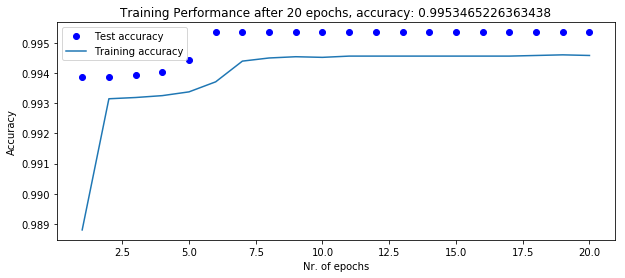

Confusion matrix, without normalization


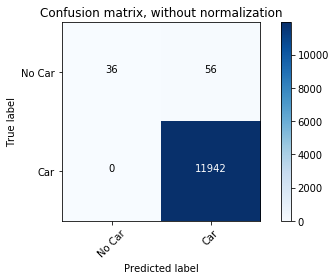

NameError: name 'y_pred_labels' is not defined

In [14]:
##### Hyperparameters
sgd = optimizers.SGD(lr=0.01)
adam = keras.optimizers.Adam()
batchsize = 200
epochs = 20
optimizer = adam
activation = 'sigmoid'
minDelta = 0
patience = 50

print ( ' Activation: '+activation+ ', Optimizer: '+str(optimizer)+
        ', Batch size: '+ str(batchsize)+' Stops at '+
       str(patience) + ' epochs, if no minimum improvement of: ' + str(minDelta))

Network = Net(batchsize, epochs, optimizer, activation, minDelta, patience)

Network.exeModel(x_train, x_test, y_train, y_test)
plot_wrongs()

In [ ]:
def visualise_data(X, Y1, Y2, meta):
    X[10], Y1[10], Y2[10], meta[10]
    
    max_len = max([len(xi) for xi in X])
    print('Maximal sequence length: '+ str(max_len))
    print('Shape of input data: ', str(np.shape(X)))
    print('Histogram of sequence length: ')
    seq_lens = []

    for xi in X:
        seq_lens.append(len(xi))
    matplotlib.pyplot.hist(seq_lens, bins= 30)

In [ ]:
visualise_data(X, Y1, Y2, meta)